In [1]:
import os
import sys
project_dir = os.path.abspath('../')
sys.path.append(project_dir)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np
from shac.envs import CartPoleSwingUpWarpEnv
env = CartPoleSwingUpWarpEnv(num_envs=1)

Using cached kernels


/home/ksrini/.pyenv/versions/miniconda3-latest/envs/shac/lib/python3.8/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Warp 0.6.1 initialized:
   CUDA Toolkit: 11.8, Driver: 11.8
   Devices:
     "cpu"    | x86_64
     "cuda:0" | NVIDIA GeForce RTX 3090 (sm_86)
   Kernel cache: /home/ksrini/.cache/warp/0.6.1
joint_pos_limit
[[ 0.  0.  0.  0.  0.  0.]
 [ 4. -0. -0. -4. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.]]
joint_ang_limit
[[    0.     0.     0.     0.     0.     0.]
 [    0.     0.     0.     0.     0.     0.]
 [   -0.  1000.    -0.    -0. -1000.    -0.]]


/home/ksrini/.pyenv/versions/miniconda3-latest/envs/shac/lib/python3.8/site-packages/urdfpy/urdf.py:898: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  value = np.asanyarray(value).astype(np.float)


Module warp.sim.collide load on device 'cuda:0' took 8680.74 ms


In [16]:
from shac.algorithms.shac import SHAC

In [12]:
import yaml
from shac.algorithms import SHAC

cfg_train = yaml.load(open("./logs/CartPoleWarp/shac-1/01-23-2023-21-49-54/cfg.yaml", "r"), Loader=yaml.Loader)

In [28]:
cfg_train["params"]["diff_env"]['stochastic_env'] = True
cfg_train["params"]["diff_env"]['no_grad'] = False

cfg_train["params"]["diff_env"]['name'] = "CartPoleSwingUpWarpEnv"

In [29]:
traj_opt = SHAC(cfg_train)

Setting seed: 0
joint_pos_limit
[[ 0.  0.  0.  0.  0.  0.]
 [ 4. -0. -0. -4. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.]
 ...
 [ 0.  0.  0.  0.  0.  0.]
 [ 4. -0. -0. -4. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.]]
joint_ang_limit
[[    0.     0.     0.     0.     0.     0.]
 [    0.     0.     0.     0.     0.     0.]
 [   -0.  1000.    -0.    -0. -1000.    -0.]
 ...
 [    0.     0.     0.     0.     0.     0.]
 [    0.     0.     0.     0.     0.     0.]
 [   -0.  1000.    -0.    -0. -1000.    -0.]]
num_envs =  64
num_actions =  1
num_obs =  5
Sequential(
  (0): Linear(in_features=5, out_features=64, bias=True)
  (1): ELU(alpha=1.0)
  (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): ELU(alpha=1.0)
  (5): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (6): Linear(in_features=64, out_features=1, bias=True)
  (7): Identity()
)
Parameter containing:
tensor([-1.], device='cuda:0', requires_grad=True)
Sequential(
  (0): Lin

/home/ksrini/.pyenv/versions/miniconda3-latest/envs/shac/lib/python3.8/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/ksrini/.pyenv/versions/miniconda3-latest/envs/shac/lib/python3.8/site-packages/urdfpy/urdf.py:898: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  value = np.asanyarray(value).astype(np.float)


In [52]:
load_path = "logs/CartPoleWarp/shac-1/01-23-2023-21-49-54/best_policy.pt"
traj_opt.load(load_path)

In [32]:
obs = traj_opt.env.reset()

Module warp.sim.articulation load on device 'cuda:0' took 1346.84 ms


In [58]:
env = traj_opt.env
env.visualize = True
env.stochastic_init = False
env.initialize_renderer("./logs/CartPoleWarp/shac-1/01-23-2023-21-49-54/deterministic_trajectory.usd")

obs = env.reset()
rew_total = 0
for i in range(240):
    obs = traj_opt.obs_rms.normalize(obs)
    obs, rew, done, info = env.step(torch.tanh(traj_opt.actor(obs, deterministic=True)))
    rew_total += rew.detach().cpu().numpy()

In [59]:
rew_total.max()

-2362.441

In [ ]:
def test_fn(actions, plot=False):
    ob_vec = []
    ob_vec.append(env.reset().detach().cpu().numpy().flatten())
    for _ in range(20):
        obs, reward, done, info = env.step(actions)
        ob_vec.append(obs.detach().cpu().numpy().flatten())
    if plot:
        ob_vec = np.array(ob_vec)
        fig, axs = plt.subplots(nrows=1, ncols=ob_vec.shape[1], figsize=(3*ob_vec.shape[1], 4))
        for i in range(ob_vec.shape[1]):
            axs[i].plot(ob_vec[:, i])
            axs[i].grid()
        plt.suptitle('without IK')
        plt.show()
    return reward


def check_grad(fn, inputs, eps=1e-6, atol=1e-4, rtol=1e-6):
    out = fn(inputs)
    out.backward()
    analytical = inputs.grad.clone()
    x2, x1 = inputs + eps, inputs - eps
    numerical = (fn(x2) - fn(x1)) / (2 * eps)
    assert torch.allclose(numerical, analytical, rtol, atol), "numerical gradient was: {}, analytical was: {}".format(numerical, analytical)
    return (numerical, analytical)

In [62]:
env.reset().detach().cpu().numpy().flatten()
model, integrator = env.model, env.integrator
state = env.state
joint_q, joint_qd = env.joint_q, env.joint_qd
bodies_before, bodies_after, bodies_after_sim = [], [], []
actions = torch.tensor([[0.]], dtype=torch.float32, device='cuda', requires_grad=True)

for _ in range(20):
    state, joint_q, joint_qd, reward, bodies = warp_step(model, state, joint_q, joint_qd, integrator, actions, num_envs=env.num_envs)
    bodies_before.append([x[0] for x in bodies])
    bodies_after.append([x[1] for x in bodies])
    bodies_after_sim.append([x[2] for x in bodies])


In [63]:
bodies_before = np.concatenate(bodies_before)
bodies_after = np.concatenate(bodies_after)
bodies_after_sim = np.concatenate(bodies_after_sim)

In [64]:
bodies_before.shape

(80, 3, 7)

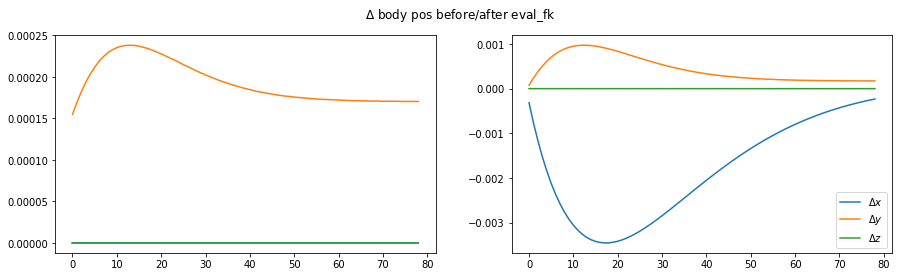

In [69]:
f, ax = plt.subplots(ncols=2, figsize=(15, 4))
for i in range(1,3):
    ax[i-1].plot(bodies_after[1:, i, :3] - bodies_before[1:, i, :3])
plt.suptitle("$\Delta$ body pos before/after eval_fk")
plt.legend(['$\Delta x$', '$\Delta y$', '$\Delta z$'])
plt.show()

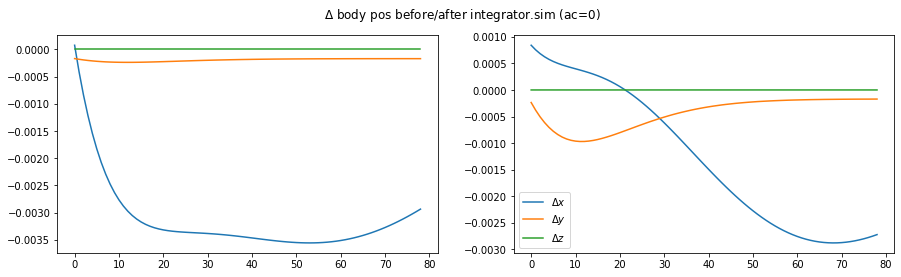

In [68]:
f, ax = plt.subplots(ncols=2, figsize=(15, 4))
for i in range(1, 3):
    ax[i-1].plot(bodies_after_sim[1:, i, :3] - bodies_after[1:, i, :3])
plt.suptitle("$\Delta$ body pos before/after integrator.sim (ac=0)")
plt.legend(['$\Delta x$', '$\Delta y$', '$\Delta z$'])
plt.show()

Module utils.warp_utils load on device 'cuda:0' took 0.35 ms
Module warp.sim.articulation load on device 'cuda:0' took 0.80 ms
Module warp.sim.integrator_euler load on device 'cuda:0' took 1.88 ms


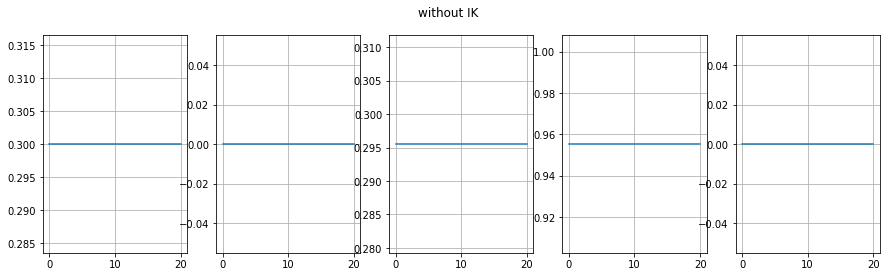

tensor([-0.0945], device='cuda:0', grad_fn=<SubBackward0>)

In [5]:
action = torch.zeros((env.num_envs, env.num_actions), requires_grad=True, device='cuda')
test_fn(action, plot=True)

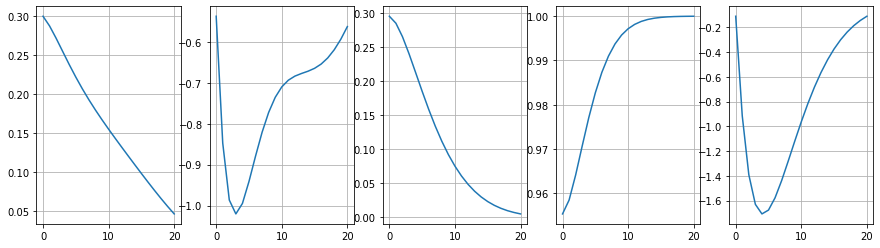

tensor([-0.0330], device='cuda:0', grad_fn=<SubBackward0>)

In [11]:
action = torch.zeros((env.num_envs, env.num_actions), requires_grad=True, device='cuda')
test_fn(action, plot=True)

In [17]:
obs = env.reset()

env.step(action)

(tensor([[ 0.0000e+00,  0.0000e+00,  8.7423e-08, -1.0000e+00,  0.0000e+00]],
        device='cuda:0', grad_fn=<CatBackward0>),
 tensor([-9.8696], device='cuda:0', grad_fn=<SubBackward0>),
 tensor([0], device='cuda:0'),
 {})

In [14]:
action = torch.zeros((env.num_envs, env.num_actions), requires_grad=True, device='cuda')
a2 = torch.tensor([[0.5]], requires_grad=True, device='cuda')
a2 = torch.tensor([[0.75]], requires_grad=True, device='cuda')

In [16]:
test_fn(a2)

tensor([-9.8696], device='cuda:0', grad_fn=<SubBackward0>)

In [15]:
check_grad(test_fn, a2)

(tensor([0.], device='cuda:0', grad_fn=<DivBackward0>),
 tensor([[0.]], device='cuda:0'))

In [17]:
rew = test_fn(action)

particle_q
particle_qd
particle_mass
particle_inv_mass
shape_geo_scale
shape_contact_thickness
spring_rest_length
spring_stiffness
spring_damping
spring_control
tri_activations
tri_materials
edge_rest_angle
edge_bending_properties
tet_activations
tet_materials
body_com
joint_axis
joint_armature
joint_target_ke
joint_target_kd
joint_target
joint_linear_compliance
joint_angular_compliance
joint_limit_lower
joint_limit_upper
particle_q_original
muscle_params
muscle_points
muscle_activation
body_mass
body_inv_mass
joint_limit_ke
joint_limit_kd
soft_contact_body_pos
soft_contact_body_vel
soft_contact_normal
rigid_contact_point0
rigid_contact_point1
rigid_contact_offset0
rigid_contact_offset1
rigid_contact_normal
rigid_contact_thickness
rigid_active_contact_point0
rigid_active_contact_point1
rigid_active_contact_distance
rigid_active_contact_distance_prev
rigid_contact_inv_weight


tensor([-11.4972], device='cuda:0', grad_fn=<SubBackward0>)

In [18]:
Out[17].backward()

In [25]:
model_vars = """particle_q
particle_qd
particle_mass
particle_inv_mass
shape_geo_scale
shape_contact_thickness
spring_rest_length
spring_stiffness
spring_damping
spring_control
tri_activations
tri_materials
edge_rest_angle
edge_bending_properties
tet_activations
tet_materials
body_com
joint_axis
joint_armature
joint_target_ke
joint_target_kd
joint_target
joint_linear_compliance
joint_angular_compliance
joint_limit_lower
joint_limit_upper
particle_q_original
muscle_params
muscle_points
muscle_activation
body_mass
body_inv_mass
joint_limit_ke
joint_limit_kd
soft_contact_body_pos
soft_contact_body_vel
soft_contact_normal
rigid_contact_point0
rigid_contact_point1
rigid_contact_offset0
rigid_contact_offset1
rigid_contact_normal
rigid_contact_thickness
rigid_active_contact_point0
rigid_active_contact_point1
rigid_active_contact_distance
rigid_active_contact_distance_prev
rigid_contact_inv_weight""".split("\n")

In [ ]:
for var in model_vars:
    if getattr(env.model, var)

In [21]:
env.state.body_f.grad.numpy()

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)